In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/opt/models/elmo/ner/results')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/opt/models/elmo/ner/results/harem-ft_ELMo+Embeddings
/opt/models/elmo/ner/results/harem_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('metrics.json not found for %s' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

metrics.json not found for harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_7
37
37


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str,'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, SCENARIO, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Scenario',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 7:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], SCENARIO: data[4], TRAINING_NUMBER: data[5], EXECUTION_NUMBER: data[6]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '7']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '4']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '9']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '1']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '2']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '1']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '0']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '4']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '3']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'total', '0', '5']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '3']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip', 'selective', '0', '8']
['harem-ft', 'ELMo+Embeddings', 'wang2vec', 'skip

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
training_data_df 

,Training_ID,Scenario,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft_ELMo+Embeddings_wang2vec_skip_selecti...,selective,harem-ft,ELMo+Embeddings,wang2vec,skip,0,7,28,53,01:01:25,3685.0,69.528302,0.999451,0.999474,0.995408,0.993797,0.994602,0.894387,0.980767,0.983171,0.851282,0.846939,0.849105,111.273824,0.977921,0.979737,0.841822,0.783639,0.811689,134.040823
1,harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_4,total,harem-ft,ELMo+Embeddings,wang2vec,skip,0,4,49,74,01:14:32,4472.0,60.432432,0.999513,0.999558,0.995773,0.995330,0.995552,1.088688,0.986285,0.987167,0.882000,0.866405,0.874133,84.459221,0.965478,0.967310,0.781596,0.738783,0.759587,235.692100
2,harem-ft_ELMo+Embeddings_wang2vec_skip_selecti...,selective,harem-ft,ELMo+Embeddings,wang2vec,skip,0,9,33,58,01:02:41,3761.0,64.844828,0.999687,0.999720,0.996494,0.996494,0.996494,0.772341,0.980986,0.983281,0.837905,0.857143,0.847415,114.206813,0.978927,0.980653,0.834200,0.803005,0.818306,136.994549
3,harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_1,total,harem-ft,ELMo+Embeddings,wang2vec,skip,0,1,24,49,00:50:03,3003.0,61.285714,0.999264,0.999286,0.992000,0.992662,0.992331,1.422941,0.986873,0.986971,0.869565,0.864440,0.866995,50.661988,0.964608,0.966364,0.781375,0.750619,0.765689,166.062664
4,harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_0,total,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,50,75,02:18:18,8298.0,110.640000,0.999513,0.999513,0.995109,0.995330,0.995220,0.820906,0.985795,0.986285,0.866667,0.868369,0.867517,73.262540,0.964653,0.966784,0.772636,0.739884,0.755906,215.378812
5,harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_2,total,harem-ft,ELMo+Embeddings,wang2vec,skip,0,2,27,52,00:53:50,3230.0,62.115385,0.999343,0.999400,0.993999,0.994441,0.994220,1.553401,0.985208,0.985697,0.867589,0.862475,0.865025,62.244601,0.964968,0.967144,0.760391,0.750344,0.755334,168.674141
6,harem-ft_ELMo+Embeddings_wang2vec_skip_selecti...,selective,harem-ft,ELMo+Embeddings,wang2vec,skip,0,1,28,53,01:08:48,4128.0,77.886792,0.999653,0.999687,0.995953,0.995415,0.995684,0.641513,0.980221,0.982406,0.866841,0.846939,0.856774,116.466141,0.977906,0.979752,0.851009,0.774290,0.810839,137.513199
7,harem-ft_ELMo+Embeddings_wang2vec_skip_selecti...,selective,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,25,50,01:16:09,4569.0,91.380000,0.999496,0.999530,0.994599,0.993258,0.993928,1.142404,0.982734,0.984701,0.841191,0.864796,0.852830,95.755948,0.978161,0.979737,0.829127,0.811686,0.820314,127.744842
8,harem-ft_ELMo+Embeddings_wang2vec_skip_selecti...,selective,harem-ft,ELMo+Embeddings,wang2vec,skip,0,4,11,36,00:51:19,3079.0,85.527778,0.999463,0.999485,0.994334,0.993797,0.994065,1.268686,0.981204,0.983281,0.841709,0.854592,0.848101,74.437282,0.978507,0.980188,0.834326,0.795326,0.814359,82.927469
9,harem-ft_ELMo+Embeddings_wang2vec_skip_total_0_3,total,harem-ft,ELMo+Embeddings,wang2vec,skip,0,3,62,75,01:17:13,4633.0,61.773333,0.999502,0.999513,0.994888,0.995330,0.995109,0.978724,0.987853,0.988147,0.880000,0.864440,0.872151,72.564364,0.963812,0.966319,0.777939,0.735756,0.756260,240.998546


In [10]:
training_data_df.to_csv('training_data_75_epochs_mestrado.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'1:09:25.864865'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
scenario_map = {'selective': 'Seletivo', 'total': 'Total'}
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**scenario_map, **model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_75_epochs_mestrado.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv(['Cenário', 'Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Scen_Model_Rep_Emb_Emb-Typ', [SCENARIO, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem  \
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor             
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram          10.0   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram          10.0   
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram           7.0   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram          10.0   

                                                             F-Score  \
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor              
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram      81.732287   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      81.249764   
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram      75.875706   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      75.300361   

                                                           Desvio Padrão  \
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor                  
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram           0.570980   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram           0.554954   
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram           0.500579   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram           0.591657   

                                                              Mínimo  \
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor              
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram      80.805006   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      80.225989   
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram      75.313808   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      74.498246   

                                                                25%       50%  \
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor                       
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram      0.812357  0.819050   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      0.810723  0.812639   
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram      0.755620  0.756260   
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      0.749089  0.752506   

                                                                75%     Máximo  
Cenário  Ajuste Fino Representação Vetor    Tipo de Vetor                       
Seletivo Sim         ELMo+Vetor    Wang2Vec Skip-Gram      0.822035  82.442221  
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      0.815582  82.036238  
Total    Sim         ELMo+Vetor    Wang2Vec Skip-Gram      0.762487  76.568861  
         Não         ELMo+Vetor    Wang2Vec Skip-Gram      0.756994  76.344837

In [14]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,,count,mean,std,min,25%,50%,75%,max
Embedding,Embedding_Type,,,,,,,,
wang2vec,skip,37.0,0.787555,0.030669,0.744982,0.75626,0.805445,0.81484,0.824422


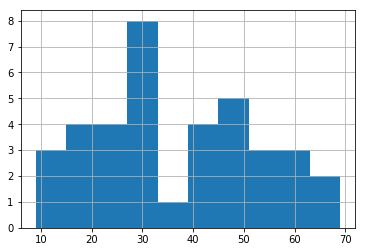

In [15]:
training_data_df[BEST_EPOCH].hist()

In [16]:
training_data_df[TOTAL_DURATION].describe()

count      37.000000
mean     4165.864865
std      1136.731551
min      1992.000000
25%      3454.000000
50%      4195.000000
75%      4616.000000
max      8298.000000
Name: Total_Duration(s), dtype: float64

In [17]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,37.0,0.787555,0.030669,0.744982,0.75626,0.805445,0.81484,0.824422


In [18]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,37.0,0.787555,0.030669,0.005042,0.777329,0.797781


In [19]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
wang2vec,37,0.787555,0.030669,0.005042,0.777673,0.797437


In [20]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [21]:
print_anova(EMBEDDING)

Overall model F( 0, 36) =  nan, p =  nan
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 03 Jun 2019   Prob (F-statistic):                nan
Time:                        07:11:26   Log-Likelihood:                 76.932
No. Observations:                  37   AIC:                            -151.9
Df Residuals:                      36   BIC:                            -150.3
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

/home/user/anaconda3/envs/allennlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1554: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


ValueError: must have at least one row in constraint matrix

In [ ]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]